In [12]:
from os import path
import pandas as pd
import seaborn as sns; sns.set()
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.vq import vq, kmeans
from matplotlib.patches import Patch, Ellipse
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
plt.style.use('seaborn-dark-palette')

In [13]:
# Importing data
df = pd.read_csv("../data/tables/metadata_table.csv", sep=";")
# Converting GC to %
df["GC"] = df["GC"].apply(lambda n: n * 100)

In [14]:
df["Proposed Name"] = df["New_Genus"] + " " + df["New_Species"] + " " + df["Strain"]

In [15]:
# # Generating Table_S1. Uncomment if you want to overwrite.
# df[[
#     "organism_name",
#     "New_Genus",
#     "New_Species",
#     "Strain",
#     "assembly_accession",
#     "bioproject",
#     "biosample",
#     "Completeness",
#     "Contamination",
#     "submitter",
#     "seq_rel_date",
#     "Size",
#     "GC"
# ]].to_csv("../data/tables/Table_S1.csv", index=False)

In [16]:
# Adding column of number of genomes per genus and species
df["No_genus"] = df.groupby('New_Genus')['New_Genus'].transform('count').map(int, na_action="ignore")
df["No_species"] = df.groupby('New_Species')['New_Species'].transform('count').map(int, na_action="ignore")

# Adding a formatted name to use in your legends
df["name_fmt"] = df["New_Genus"] + " ("+ df["No_genus"].map(int, na_action="ignore").map(str) + ")"
df["name_fmt"] = df["name_fmt"].apply(lambda s: s.replace(".0", "") if type(s) == str else s)

In [17]:
def raw(str):
    return r'${}$'.format(str)

In [18]:
df["name_fmt2"] = df["name_fmt"].apply(lambda s: str(s).replace("Synechospongium", "Synechospongium\ \mathrm{gen. nov.}"))
df["name_fmt2"] = df["name_fmt2"].apply(lambda s: str(s).replace("Lacustricoccus", "Lacustricoccus\ \mathrm{gen. nov.}"))
df["name_fmt2"] = df["name_fmt2"].apply(lambda s: raw(str(s).replace(" (", "\ (")))

In [19]:
# Applying QC
df = df.query("Completeness >= 50 & Contamination <= 10 & No_genus > 1")

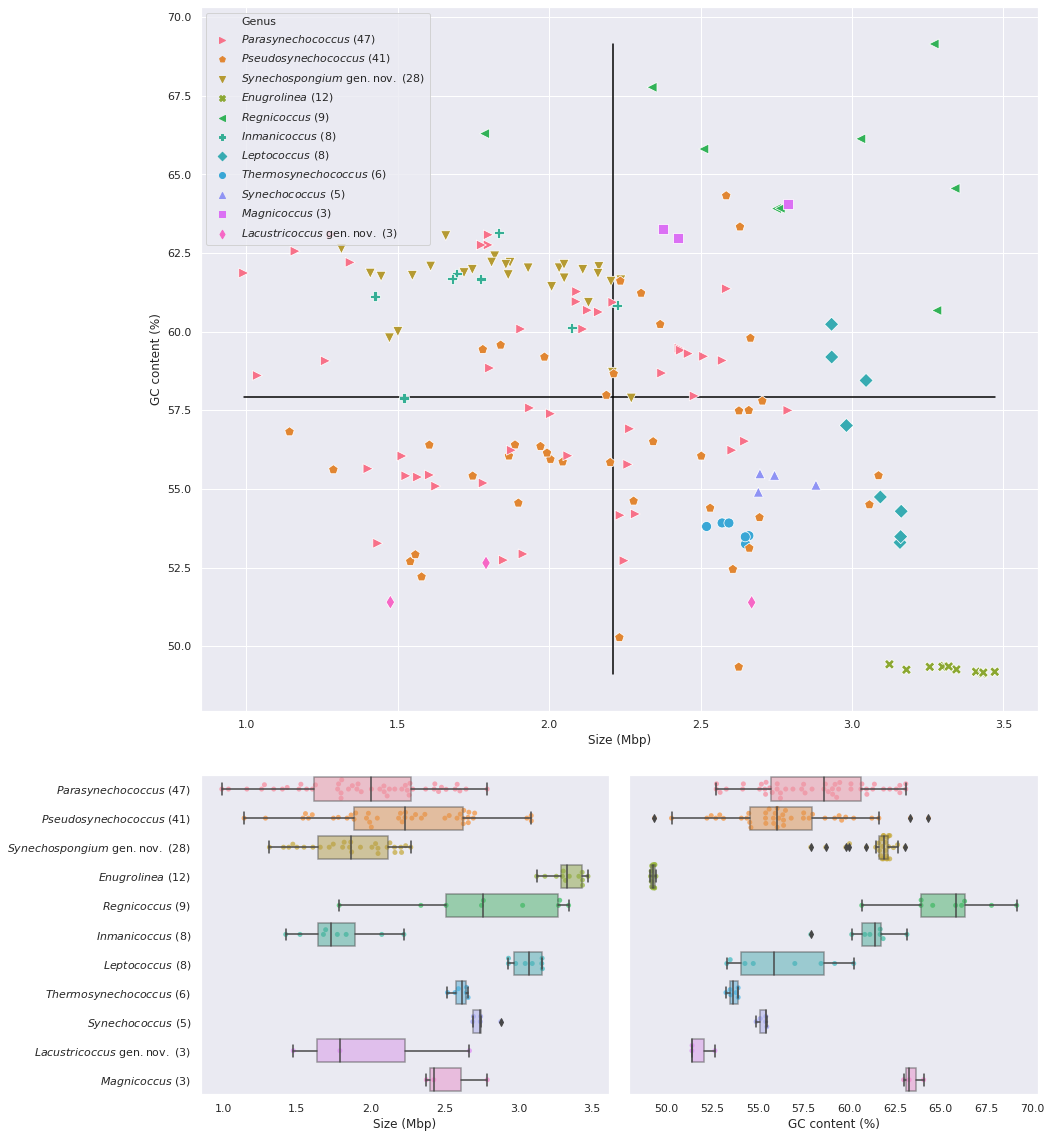

In [9]:
# Large plot
fig = plt.figure(figsize=(15, 20))

gs = GridSpec(
    nrows=3, ncols=2, height_ratios=[1,1,1], wspace=0.05
)

max_s, min_s, median_s = max_s, min_s, median_s = df["Size"].max(), df["Size"].min(), df["Size"].median()
max_gc, min_gc, median_gc = df["GC"].max(), df["GC"].min(), df["GC"].median()
order = list(df["name_fmt2"].value_counts().index)
filled_markers = ('o', 'v', '^', '<', 'p', '>', 's', 'D', 'd', 'P', 'X', )

# Scatter plot
ax0 = fig.add_subplot(gs[:2, :])
ax0.plot([max_s, min_s], [median_gc, median_gc], color="black", zorder=1)
ax0.plot([median_s, median_s], [max_gc, min_gc], color="black", zorder=1)
sns.scatterplot(
            x="Size",
            y="GC",
            data=df.sort_values(
                by="No_genus", ascending=False
            ),
            hue=df["name_fmt2"],
            style=df["name_fmt2"],
            hue_order=order,
            s=100,
            zorder=2,
            markers=filled_markers,
            ax=ax0,
        )
legend = ax0.legend()
legend.texts[0].set_text("Genus")

# Size plot
ax1 = fig.add_subplot(gs[2, 0])
sns.boxplot(
    y="name_fmt2",
    x="Size",
    data=df.sort_values(
        by="No_genus", ascending=False
    ),
    boxprops=dict(alpha=.5),
    ax=ax1)
sns.swarmplot(
    y="name_fmt2",
    x="Size",
    data=df.sort_values(
        by="No_genus", ascending=False
    ),
        hue="name_fmt2",
    alpha=0.7,
    zorder=0,
    ax=ax1)

# GC plot
ax2 = fig.add_subplot(gs[2, 1], sharey=ax1)
sns.boxplot(
    y="name_fmt2",
    x="GC",
    data=df.sort_values(
        by="No_genus", ascending=False
    ),
    boxprops=dict(alpha=.5),
    ax=ax2)
sns.swarmplot(
    y="name_fmt2",
    x="GC",
    data=df.sort_values(
        by="No_genus", ascending=False)
    ,
    hue="name_fmt2",
    alpha=0.7,
    zorder=0,
    ax=ax2)


# Hiding legends
plt.setp(ax2.get_yticklabels(), visible=False)
ax1.legend().remove()
ax2.legend().remove()
ax1.grid(False)
ax2.grid(False)

# Fixing labels
ax0.set_xlabel("Size (Mbp)")
ax0.set_ylabel("GC content (%)")
ax1.set_xlabel("Size (Mbp)")
ax1.set_ylabel("")
ax2.set_xlabel("GC content (%)")
ax2.set_ylabel("")

plt.savefig("../data/plots/Figure_1_concat.png", dpi=700, bbox_inches="tight",)


In [10]:
# Basis for Table 1
df.groupby("New_Genus").describe().round(2)[["Size", "GC"]][
    [
        ("Size", "mean"),
        ("Size", "std"),
        ("GC", "mean"),
        ("GC", "std"),
        ("Size", "count"),
    ]
].sort_values(("Size", "count"), ascending=False).to_csv("../data/tables/Table_1.csv")

# Removing the multiindex
!tail -n 11 ../data/tables/Table_1.csv > ../data/tables/Table_1_basis.csv
!sed -i '1s/^/Genus,Size mean (Mb),Size std,GC % mean,GC % std,No_genomes\n/' ../data/tables/Table_1_basis.csv
!rm ../data/tables/Table_1.csv

In [11]:
# # Creating GToTree input - uncomment if you wish to generate it.
# df["proteins_file"].to_csv("../data/gtt/gtt_input.csv", index=False, header=False)
# df["proteins_file_fmt"] = df["proteins_file"].apply(lambda s: path.basename(s))
# df[["proteins_file_fmt", "Proposed Name"]].to_csv("../data/gtt/gtt_labels.tsv", index=False, header=False, sep="\t")

# # Add Prochlorococcus marinus to root the tree (GCA_000007925.1)
# !echo "/home/vini/data/prosyn/processing/prodigal/proteins/GCA_000007925.1_ASM792v1_genomic_prodigal_proteins.faa" >> ../data/gtt/gtt_input.csv
# !echo "GCA_000007925.1_ASM792v1_genomic_prodigal_proteins.faa\tProchlorococcus marinus CCMP1375" >> ../data/gtt/gtt_labels.tsv